<h2> We try a simple logit model for telephone data </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice

In [3]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [4]:
# Load data
data = pd.read_csv('../data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [5]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935


In [6]:
data.head()

,choice,area,users,inc,age0,age1,age2,age3,age4,age5,...,U_2,U_3,U_4,U_5,P_1,P_2,P_3,P_4,P_5,P
0,2,1,2,4,0,0,0,1,1,0,...,-3.554780,-3.956500,-26.993845,-4.641269,0.192843,0.402258,0.269178,0.0,0.135721,0.402258
1,3,1,1,2,0,0,0,0,0,0,...,-3.554780,-3.880397,-26.993845,-4.641269,0.392023,0.295209,0.213165,0.0,0.099603,0.213165
2,1,2,2,4,0,0,0,2,0,0,...,-3.554780,-3.742135,-26.993845,-5.035488,0.234203,0.372356,0.308739,0.0,0.084702,0.234203
3,3,2,2,3,1,0,0,0,2,0,...,-3.554780,-3.555367,-26.993845,-5.035488,0.245235,0.338932,0.338733,0.0,0.077099,0.338733
4,3,2,6,3,1,3,2,1,0,2,...,-3.957232,-4.193209,-26.993845,-5.035488,0.133748,0.406694,0.321206,0.0,0.138353,0.321206


---
---
---
---
---

<h2> Applying DIB algorithm </h2>

<h2> Now that we consider continous random variables for the cost, we use f(x) instead of p(x) in the different formulas </h2>

<h2> Multinomial lognormal distribution on raw data </h2>

In [7]:
from functions_geom_DIB import geom_DIB_on_alternatives

In [8]:
from scipy.stats import multivariate_normal

In [9]:
def multivariate_lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a multivariate lognormal distribution.

    Parameters:
        x (ndarray): Vector in log space.
        mu (ndarray): Mean vector.
        sigma (ndarray): Covariance matrix.

    Returns:
        float: Value of the PDF at x.
    """
    n = len(x)
    
    # Compute the PDF of a multivariate normal distribution
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    mvn_pdf = (1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(sigma)))) * np.exp(exponent)
    
    # Compute the Jacobian determinant term and remove x = 0 elements
    jacobian = np.prod(1 / x)

    pdf = jacobian * mvn_pdf

    # Compute the PDF of the multivariate lognormal distribution
    
    return pdf

In [9]:
# from scipy.stats import t

In [10]:
data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']].corr()

,logcost1,logcost2,logcost3,logcost4,logcost5
logcost1,1.000000,0.948294,0.727360,-0.199374,-0.122304
logcost2,0.948294,1.000000,0.790817,-0.251399,-0.198625
logcost3,0.727360,0.790817,1.000000,-0.221227,-0.497434
logcost4,-0.199374,-0.251399,-0.221227,1.000000,0.117603
logcost5,-0.122304,-0.198625,-0.497434,0.117603,1.000000


In [11]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()
covariance_matrix = log_df_logcost.cov()

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_8516/2939645465.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)


In [12]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values


p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [13]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [17]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=2000, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000


In [18]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
1    424
2      5
4      3
0      2
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0         1    0    0  1   0
1        71  122  175  0  56
2         0    1    3  1   0
4         1    0    0  1   1

 max_proba   1    2    3  4   5
cluster                       
0           0    0    2  0   0
1          49  110  229  0  36
2           0    0    4  1   0
4           0    0    1  1   1

 simulated_choice   1    2    3  4   5
cluster                              
0                  1    1    0  0   0
1                 70  133  161  0  60
2                  0    0    2  3   0
4                  0    1    1  0   1


In [16]:
betas = np.linspace(0, 1000, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5

KeyboardInterrupt: 

---
----
---
---
---


<h2> Multinomial lognormal distribution without missing data </h2>

In [16]:
data['true_logcost1'] = data['logcost1'] * data['avail1']
data['true_logcost2'] = data['logcost2'] * data['avail2']
data['true_logcost3'] = data['logcost3'] * data['avail3']
data['true_logcost4'] = data['logcost4'] * data['avail4']
data['true_logcost5'] = data['logcost5'] * data['avail5']
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

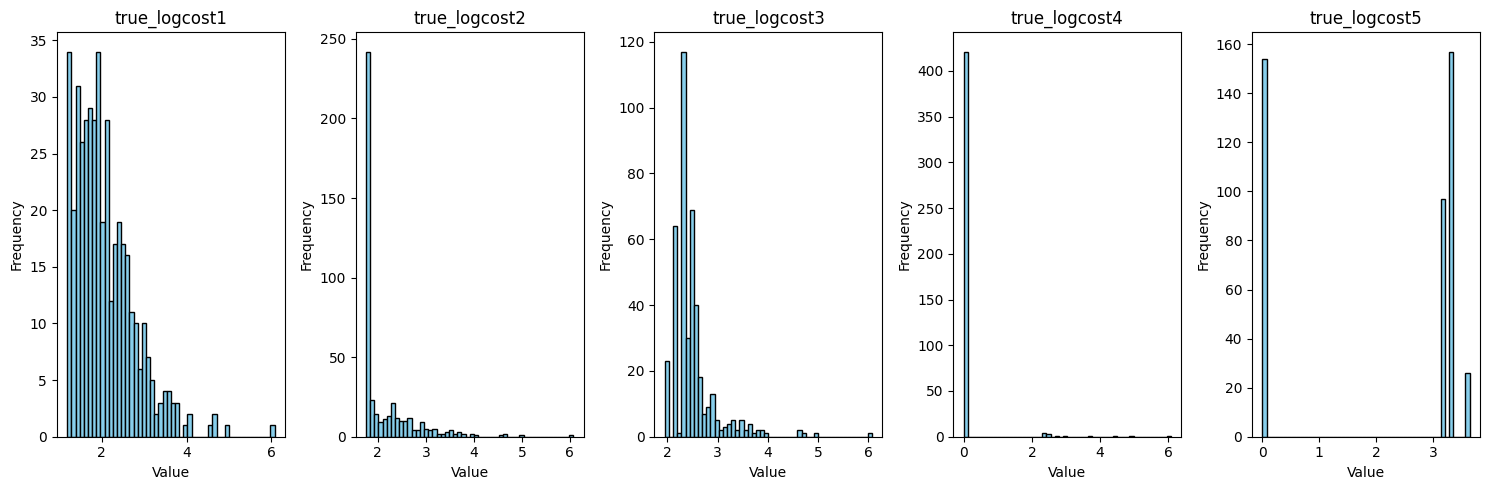

In [17]:
# Select five columns for plotting histograms
columns_to_plot = ['true_logcost1', 'true_logcost2', 'true_logcost3', 'true_logcost4', 'true_logcost5']

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot histograms for each selected column
for i, col in enumerate(columns_to_plot):
    axs[i].hist(data[col], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
df_true_logcost = data[['true_logcost1', 'true_logcost2', 'true_logcost3', 'true_logcost4', 'true_logcost5']]

df_true_logcost = df_true_logcost.replace(0, np.nan)

log_true_logcost = np.log(df_true_logcost)

mean_vector = log_true_logcost.mean()

covariance_matrix = log_true_logcost.cov()

In [19]:
test = covariance_matrix.copy()
test = test + np.eye(5) 
test

,true_logcost1,true_logcost2,true_logcost3,true_logcost4,true_logcost5
true_logcost1,1.095753,0.064655,0.029184,0.139858,0.000387
true_logcost2,0.064655,1.053884,0.025420,0.126466,0.001293
true_logcost3,0.029184,0.025420,1.023921,0.112808,0.000439
true_logcost4,0.139858,0.126466,0.112808,1.109199,0.000000
true_logcost5,0.000387,0.001293,0.000439,0.000000,1.001789


In [20]:
np.linalg.eigvals(test)

array([1.34936618, 0.90150456, 1.02645264, 1.00557192, 1.00165106])

In [21]:
df_logcost2 = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the probability density for each individual's cost vector
df_true_logcost['probability_density'] = df_logcost2.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, test), axis=1)

In [22]:
# Computation of p(x,y)
p_x = df_true_logcost['probability_density'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy
p_xy /= p_xy.sum()

# # Define epsilon value
# epsilon = 1e-40

# # Add epsilon to elements equal to 0
# p_xy[p_xy == 0] += epsilon

q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=80, max_iter=5000, threshold=1e-5)

/Users/alex/Documents/GitHub/Semester_project_information_cluser/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


Iteration: 1 out of 5000
Iteration: 2 out of 5000


Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out o

In [23]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
0    423
4      6
1      3
2      2
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0        72  122  175  1  53
1         1    0    2  0   0
2         0    1    0  1   0
4         0    0    1  1   4

 max_proba   1    2    3  4   5
cluster                       
0          49  110  231  0  33
1           0    0    3  0   0
2           0    0    2  0   0
4           0    0    0  2   4

 simulated_choice   1    2    3  4   5
cluster                              
0                 71  134  161  0  57
1                  0    1    1  1   0
2                  0    0    1  1   0
4                  0    0    1  1   4


Iteration: 1 out of 5000
Iteration: 2 out of 5000


/Users/alex/Documents/GitHub/Semester_project_information_cluser/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out o

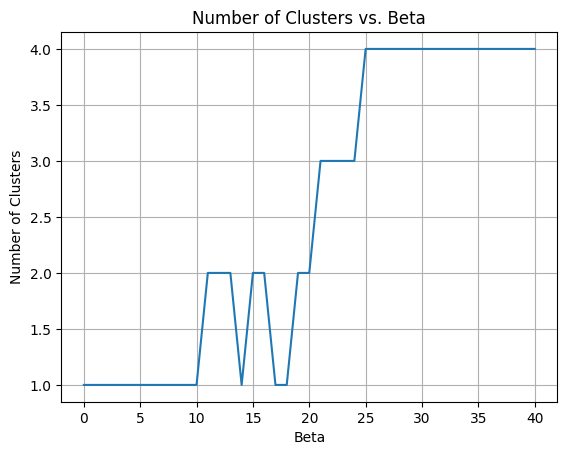

In [24]:
betas = np.linspace(0, 40, 41)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-5)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> Multinomial lognormal distribution on raw data but covariance matrix is diagonal </h2>

In [25]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

sd = log_df_logcost.std()
covariance_matrix_diagonal = np.diag(sd**2)

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_diagonal), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13097/3945173557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_diagonal), axis=1)


In [26]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=540, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [27]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
4    425
2      7
0      2
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0         1    0    0  1   0
2         1    1    3  2   0
4        71  122  175  0  57

 max_proba   1    2    3  4   5
cluster                       
0           0    0    2  0   0
2           0    0    5  2   0
4          49  110  229  0  37

 simulated_choice   1    2    3  4   5
cluster                              
0                  1    1    0  0   0
2                  0    1    3  3   0
4                 70  133  161  0  61


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

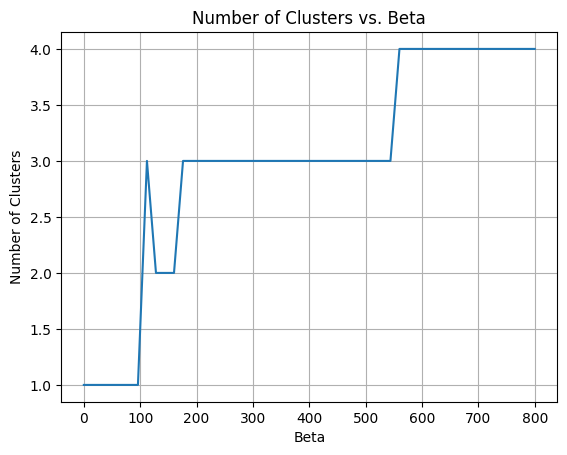

In [28]:
betas = np.linspace(0, 800, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> Multinomial lognormal distribution without missing data but covariance matrix is diagonal </h2>

In [29]:
data['true_logcost1'] = data['logcost1'] * data['avail1']
data['true_logcost2'] = data['logcost2'] * data['avail2']
data['true_logcost3'] = data['logcost3'] * data['avail3']
data['true_logcost4'] = data['logcost4'] * data['avail4']
data['true_logcost5'] = data['logcost5'] * data['avail5']

In [30]:
df_true_logcost = data[['true_logcost1', 'true_logcost2', 'true_logcost3', 'true_logcost4', 'true_logcost5']]

df_true_logcost = df_true_logcost.replace(0, np.nan)

log_true_logcost = np.log(df_true_logcost)

mean_vector = log_true_logcost.mean()

sd = log_true_logcost.std()
covariance_matrix_diagonal = np.diag(sd**2)
covariance_matrix_diagonal = np.eye(5) * 0.5

In [31]:
df_logcost2 = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the probability density for each individual's cost vector
df_true_logcost['probability_density'] = df_logcost2.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_diagonal), axis=1)

In [32]:
# Computation of p(x,y)
p_x = df_true_logcost['probability_density'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy
p_xy /= p_xy.sum()

# # Define epsilon value
# epsilon = 1e-40

# # Add epsilon to elements equal to 0
# p_xy[p_xy == 0] += epsilon

q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=25, max_iter=5000, threshold=1e-5)

/Users/alex/Documents/GitHub/Semester_project_information_cluser/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000


In [33]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 2

 cluster
0    431
3      3
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0        73  123  178  3  54
3         0    0    0  0   3

 max_proba   1    2    3  4   5
cluster                       
0          49  110  236  2  34
3           0    0    0  0   3

 simulated_choice   1    2    3  4   5
cluster                              
0                 71  135  164  3  58
3                  0    0    0  0   3


Iteration: 1 out of 5000
Iteration: 2 out of 5000


/Users/alex/Documents/GitHub/Semester_project_information_cluser/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out o

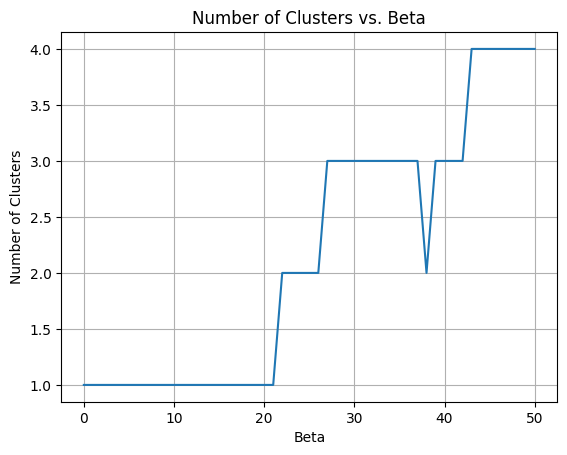

In [34]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()